In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [25]:
DATA_FILENAME = "https://raw.githubusercontent.com/amankharwal/Website-data/master/car%20data.csv"
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [26]:
input_cols = ["Year","Present_Price","Kms_Driven","Owner"]
categorical_cols = ["Fuel_Type","Seller_Type","Transmission"]
output_cols = ["Selling_Price"]


In [27]:
def dataframe_to_arrays(df):
    df_copy = df.copy(deep=True)
    for col in categorical_cols:
        df_copy[col] = df_copy[col].astype('category').cat.codes
    X = df_copy[input_cols].to_numpy(dtype=float)
    y = df_copy[output_cols].to_numpy(dtype=float)
    return X, y

inputs_array, targets_array = dataframe_to_arrays(dataframe)


In [28]:
scaler_X = StandardScaler()
inputs_scaled = scaler_X.fit_transform(inputs_array)

inputs = torch.Tensor(inputs_scaled)
targets = torch.Tensor(targets_array)  # keep target in real price units


In [29]:
dataset = TensorDataset(inputs, targets)
train_ds, val_ds = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)


In [30]:
input_size = len(input_cols)
output_size = len(output_cols)

class CarsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, output_size)
        
    def forward(self, xb):
        xb = F.relu(self.fc1(xb))
        out = self.fc2(xb)
        return out  # raw output, we’ll clamp later if needed
    
    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
            print(f"Epoch [{epoch+1}/{num_epochs}], val_loss: {result['val_loss']:.4f}")

model = CarsModel()


In [31]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history


In [32]:
epochs = 300
lr = 1e-2
history = fit(epochs, lr, model, train_loader, val_loader)


Epoch [10/300], val_loss: 0.8353
Epoch [20/300], val_loss: 0.8650
Epoch [30/300], val_loss: 0.8341
Epoch [40/300], val_loss: 0.8312
Epoch [50/300], val_loss: 0.8107
Epoch [60/300], val_loss: 0.8250
Epoch [70/300], val_loss: 0.8247
Epoch [80/300], val_loss: 0.8051
Epoch [90/300], val_loss: 0.8106
Epoch [100/300], val_loss: 0.7892
Epoch [110/300], val_loss: 0.7910
Epoch [120/300], val_loss: 0.8114
Epoch [130/300], val_loss: 0.8233
Epoch [140/300], val_loss: 0.7873
Epoch [150/300], val_loss: 0.8031
Epoch [160/300], val_loss: 0.7953
Epoch [170/300], val_loss: 0.7983
Epoch [180/300], val_loss: 0.8167
Epoch [190/300], val_loss: 0.8193
Epoch [200/300], val_loss: 0.7817
Epoch [210/300], val_loss: 0.7624
Epoch [220/300], val_loss: 0.7760
Epoch [230/300], val_loss: 0.8060
Epoch [240/300], val_loss: 0.7643
Epoch [250/300], val_loss: 0.7513
Epoch [260/300], val_loss: 0.7648
Epoch [270/300], val_loss: 0.7638
Epoch [280/300], val_loss: 0.7848
Epoch [290/300], val_loss: 0.7791
Epoch [300/300], val_lo

In [33]:
final_result = evaluate(model, val_loader)
print("Final validation loss:", final_result['val_loss'])


Final validation loss: 0.794488787651062


In [34]:
# Predict a new car price
example_input = torch.Tensor(scaler_X.transform([[2020, 10.5, 5000, 0]]))
pred = model(example_input).detach().numpy()
pred_price = max(0, pred[0][0])  # clamp to >= 0
print("Predicted Selling Price:", round(pred_price, 2))


Predicted Selling Price: 14.18


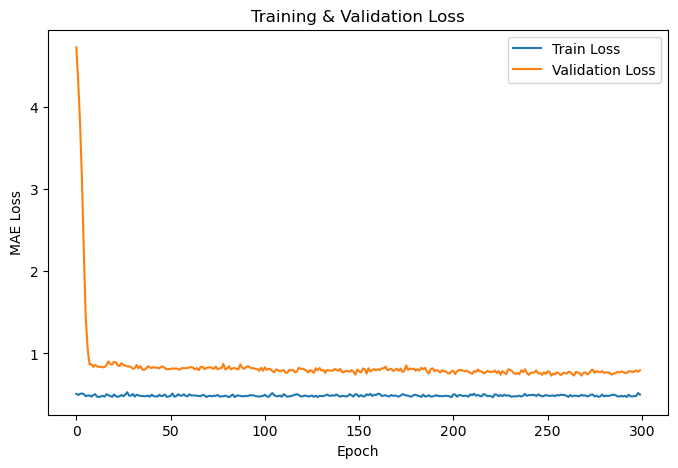

In [35]:
import matplotlib.pyplot as plt

# Extract losses from history
train_losses = []
val_losses = []

for epoch in range(len(history)):
    val_losses.append(history[epoch]['val_loss'])

# Since we used batch training, we can approximate train_loss per epoch
# Optionally, compute train loss after each epoch
for epoch in range(len(history)):
    batch_losses = [model.training_step(batch).item() for batch in train_loader]
    train_losses.append(sum(batch_losses)/len(batch_losses))

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()
